Author: Max Boleininger

UK Atomic Energy Authority, 2022

# Processing threshold displacement energies for alloys

In [15]:
import numpy as np
import scipy

from matplotlib import pyplot as plt
from scipy.spatial import cKDTree

from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add lib path to sys.path (needed to import the Lindhard model)
sys.path.insert(0, "%s/lib/" % parent_dir)

from lindhard import Lindhard

In [19]:
# import crystallographic point group transformations
fcctrans = np.loadtxt("./crystal-symmetries/fcc_transformations.dat")
bcctrans = np.loadtxt("./crystal-symmetries/bcc_transformations.dat")
hcptrans = np.loadtxt("./crystal-symmetries/hcp_transformations.dat")

# reshape back to 3x3 transformation matrices
fcctrans = fcctrans.reshape(len(fcctrans),3,3)
bcctrans = bcctrans.reshape(len(bcctrans),3,3)
hcptrans = hcptrans.reshape(len(hcptrans),3,3)

In [28]:
# Lindhard electronic stopping model for damage energy
# build model averaged over the chance of occurrence of the specific projectile and target elements model 
# order: Ni Fe Cr
A = {0: 58.6934, 1: 55.845, 2: 51.9961} # atomic mass
Z = {0: 28, 1: 26, 2: 24}               # charge number
composition = [0.094, 0.714, 0.192]     # composition of the material 
nelements = 3                           # number of elements

# Lindhard models for all combinations of projectile and target species
tdmodels = {}
for i in range(nelements):
    for j in range(nelements):
        tdmodels[(i,j)] = Lindhard (A[i], A[j], Z[i], Z[j])

# Lindhard model averaged over abundance of target and projectile
def avg_tdmodel (pka):
    tdenergy = 0.0 
    for i in range(nelements):
        for j in range(nelements):
            tdenergy += composition[i]*composition[j]*tdmodels[(i,j)](pka)
    tdenergy *= 1/sum(composition)**2 # normalisation should not be needed, but do here just in case
    return tdenergy

tdmodel = np.vectorize (avg_tdmodel)

In [53]:
def process_displacements_fuzzy (path, tdmodel, stopping_cutoff, transformation, geo_freq=5):
    '''Import and process displacement events for alloys.'''

    # import geodesic sampling points
    # these coordinates are used for sampling E_d on the unit sphere
    # if request a value higher than 5, you will need to generate new coordinates. See geodesic-points/write_geo.py for this.
    kvec = np.loadtxt("./geodesic-points/geo.%d.dat" % geo_freq)
    
    # import displacement events. columns are:
    # energy | v_unit_x | v_unit_y | v_unit_z | nr_of_frenkel_pairs 
    pkadat = np.loadtxt(path)

    # threshold number of defects to 1 (0: no displacement damage, 1: displacement damage)
    pkadat[pkadat[:,-1]>1,-1] = 1
    
    # convert recoil energy to damage energy

    # In the Lindhard stopping model, the charged particle loses energy continuously 
    # until the point of stopping. In our molecular dynamics simulations however, we use a 
    # typical electronic stopping model that only acts on particles with kinetic energy above e.g. 10 eV.
    # Therefore, the stopping model slightly underestimates the damage energy from simulation.
    # To correct for this, we add the energy loss for 10 eV particle back to the damage energy.
    dE  = stopping_cutoff - tdmodel(stopping_cutoff)
    pkadat[:,0] = tdmodel(pkadat[:,0]) + dE # set the 0th column to damage energy

    # compute all symmetrically equivalent points:
    # x' = M.x with some list concatenation (fast)
    nt = len(transformation)
    pkadatsymm = np.einsum('kij,lj->kli', transformation, pkadat[:,1:-1]).reshape(len(pkadat)*nt,3)
    pkadat = np.array([pkadat[:,[0,-1]] for _i in range(nt)]).reshape(len(pkadat)*nt,2)

    # construct KDTree of geodesic dome vertices for quick neighbour search
    ktree = cKDTree(kvec)

    # for each randomly sampled kick, find nearest geodesic vertex 
    _,vertid = ktree.query(pkadatsymm)

    # create dictionary mapping sampled points to geodesic vertices
    cat = {}
    for i,v in enumerate(vertid):
        if v not in cat:
            cat[v] = [i]
        else:
            cat[v] += [i]

    datarr = []
    for v in range(len(kvec)):
        if v in cat:
            datarr += [[kvec[v][0], kvec[v][1], kvec[v][2], np.min(pkadat[cat[v]]), v]]
        else:
            datarr += [[kvec[v][0], kvec[v][1], kvec[v][2], 0, v]]

    # data array contains bin (geodesic coordinate), minimum threshold energy in this bin, and number of counts in this bin 
    return datarr, [pkadat[cat[v]] for v in cat]


In [64]:
ffunc = lambda p,x: p[0]*(1+np.tanh((x-p[1])/p[2])) 
cost = lambda p,args: np.sum(np.abs((ffunc(p, args[:,0]) - args[:,1]))**1)

def pdf_and_fit (_data, emax=100, pthreshold=0.1):
    '''Determine threshold energy as point where FP generation has at least pthreshold success.'''
    
    bins = np.arange(0, emax, 2.0)
    binwidths = bins[1:]-bins[:-1]
    binmids = bins[1:] + .5*binwidths

    # 0: x-axis (bin mids)
    # 1: number of hits
    # 2: number of attempts

    # bin data (including unsuccessful counts)
    _digi = np.digitize(_data[:,0], bins)

    _rawcounts = np.zeros((len(binmids),3), dtype=float)

    _rawcounts[:,0] = binmids
    for _i,_d in enumerate(_digi):
        if _d >= len(_rawcounts):
            continue
        _rawcounts[_d,1] += _data[_i,1]
        _rawcounts[_d,2] += 1

    # turn to probability
    pdf = np.copy(_rawcounts)
    _rawcounts[_rawcounts[:,2]==0,2] = 1e99

    pdf[:,1] = _rawcounts[:,1]/_rawcounts[:,2]
    pdf[:,2] = np.sqrt(_rawcounts[:,1])/_rawcounts[:,2]

    # fetch energy at which half of kicks are successful
    y=pthreshold
    ix = np.where(pdf[:,1]>y)[0][0]
    x0,y0,_ = pdf[ix-1]
    x1,y1,_ = pdf[ix]
    xv=(y-y0)/(y1-y0)*(x1-x0)+x0


    return pdf, xv



In [65]:
# Enter here the path of the log file generated with geted.py
path = "./example-data/NiFeCr_edsample.log"
stopping_cutoff = 10.0

_,pkadat = process_displacements_fuzzy (path, tdmodel, stopping_cutoff, fcctrans)
processed = [pdf_and_fit(_data, emax=80.0, pthreshold=.1) for _data in pkadat]

# compute mean and minimum Ed over geodesic vertices
edmin = np.min([tdmodel(xv)+dE for pdf,xv in processed])
edavg = np.mean([tdmodel(xv)+dE for pdf,xv in processed])

print ("Ed:     %8.4f eV" % edavg)
print ("Ed,min: %8.4f eV" % edmin)

Ed:      25.7097 eV
Ed,min:  16.7281 eV


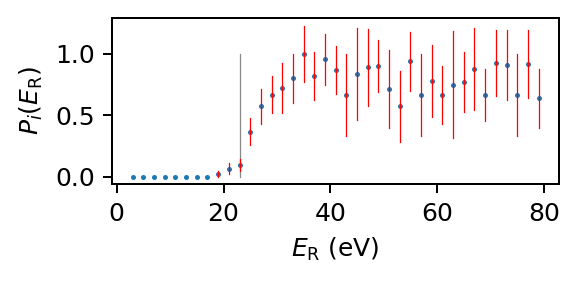

In [66]:
# visual inspection, is the fit working? 

# Plot Fig
fig = plt.figure(figsize=(3.2, 1.2), dpi=180) 
ax = fig.add_subplot(1,1,1)

pdf,xv = processed[100] # vary this to check different bins

ax.scatter(pdf[:,0], pdf[:,1], s=1)

for i in range(len(pdf)):
    ax.plot([pdf[i,0],pdf[i,0]], [pdf[i,1]-pdf[i,2],pdf[i,1]+pdf[i,2]], c='r', lw=0.5)

ax.plot([xv,xv], [0,1.], lw=.5, c='#888888', zorder=-10)
    
ax.set_xlabel(r"$E_\mathrm{R}$ (eV)")
ax.set_ylabel(r"$P_i(E_\mathrm{R})$")

plt.show()